# Modern Data Science 
**(Module A: Pattern Classification)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.
- If you found any issue/bug for this document, please submit an issue at [tulip lab/flip01](https://github.com/tulip-lab/flip01/issues)


Prepared by and for 
**Student Members** |
2006-2022 [TULIP Lab](http://www.tulip.org.au), Australia

---


# Session I - Using optimization routines from scipy and statsmodels

### Finding roots
For root finding, we generally need to provide a starting point in the vicinity of the root. For iD root finding, this is often provided as a bracket (a, b) where a and b have opposite signs.

In [1]:
%matplotlib inline

In [2]:
import scipy.linalg as la
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
np.set_printoptions(precision=3, suppress=True)

#### Univariate roots and fixed points

In [4]:
def f(x):
    return x**3-3*x+1

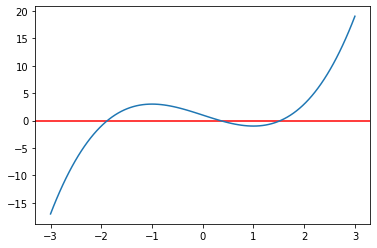

In [5]:
x = np.linspace(-3,3,100)
plt.axhline(0, c='red')
plt.plot(x, f(x));

In [6]:
from scipy.optimize import brentq, newton

brentq is the recommended method

In [7]:
brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)

(-1.8793852415718166, 0.3472963553337031, 1.532088886237956)

Secant method

In [8]:
newton(f, -3), newton(f, 0), newton(f, 3)

(-1.8793852415718166, 0.34729635533385395, 1.5320888862379578)

Newton-Raphson method

In [9]:
fprime = lambda x: 3*x**2 - 3
newton(f, -3, fprime), newton(f, 0, fprime), newton(f, 3, fprime)

(-1.8793852415718166, 0.34729635533386066, 1.532088886237956)

Analytical solution using sympy to find roots of a polynomial

In [10]:
from sympy import symbols, N, real_roots

In [11]:
x = symbols('x', real=True)
sol = real_roots(x**3 - 3*x + 1)
list(map(N, sol))

[-1.87938524157182, 0.347296355333861, 1.53208888623796]

#### Finding fixed points

Finding the fixed points of a function $g(x)=x$ is the same as finding the roots of $g(x)−x$. However, specialized algorithms also exist - e.g. using scipy.optimize.fixedpoint.

In [12]:
from scipy.optimize import fixed_point

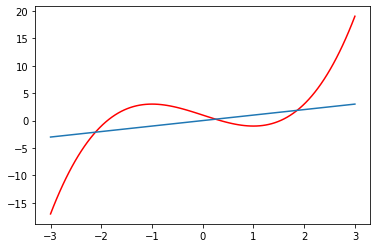

In [13]:
x = np.linspace(-3,3,100)
plt.plot(x, f(x), color='red')
plt.plot(x, x)
pass

In [14]:
fixed_point(f, 0), fixed_point(f, -3), fixed_point(f, 3)

(array(0.254), array(-2.115), array(1.861))

In [15]:
newton(lambda x: f(x) - x, 0), newton(lambda x: f(x) - x, -3), newton(lambda x: f(x) - x, 3)

(0.2541016883650525, -2.114907541476814, 1.860805853111706)

In [16]:
def f(x, r):
    """Discrete logistic equation."""
    return r*x*(1-x)

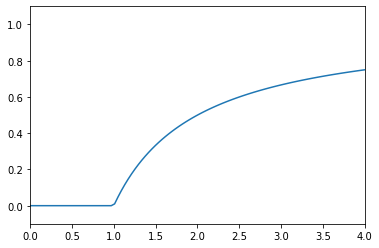

In [17]:
n = 100
fps = np.zeros(n)
for i, r in enumerate(np.linspace(0, 4, n)):
    fps[i] = fixed_point(f, 0.5, args=(r, ))

plt.plot(np.linspace(0, 4, n), fps)
plt.axis([0,4,-0.1, 1.1])
pass

##### Note that we don’t know anything about the stability of the fixed point

Beyond $r=3$, the fixed point is unstable, even chaotic, but we would never know that just from the plot above.

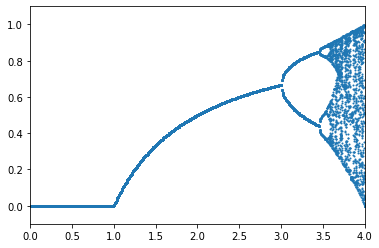

In [18]:
xs = []
for i, r in enumerate(np.linspace(0, 4, 400)):
    x = 0.5
    for j in range(10000):
        x = f(x, r)
    for j in range(50):
        x = f(x, r)
        xs.append((r, x))
xs = np.array(xs)
plt.scatter(xs[:,0], xs[:,1], s=1)
plt.axis([0,4,-0.1, 1.1])
pass

### Mutlivariate roots and fixed points

Use root to solve polynomial equations. Use fsolve for non-polynomial equations.

In [19]:
from scipy.optimize import root, fsolve

Suppose we want to solve a sysetm of m equations with $n$ unknowns

Note that the equations are non-linear and there can be multiple solutions. These can be interpreted as fixed points of a system of differential equations.

In [20]:
def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1),
            .25*x[0]**2 + x[1]**2 - 1]

In [21]:
sol = root(f, (0.5, 0.5))
sol.x

array([1.117, 0.83 ])

In [22]:
fsolve(f, (0.5, 0.5))

array([1.117, 0.83 ])

In [23]:
r0 = opt.root(f,[1,1])
r1 = opt.root(f,[0,1])
r2 = opt.root(f,[-1,1.1])
r3 = opt.root(f,[-1,-1])
r4 = opt.root(f,[2,-0.5])

roots = np.c_[r0.x, r1.x, r2.x, r3.x, r4.x]

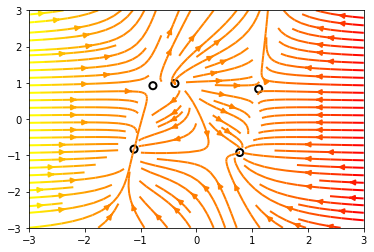

In [24]:
Y, X = np.mgrid[-3:3:100j, -3:3:100j]
U = Y - 3*X*(X + 1)*(X-1)
V = .25*X**2 + Y**2 - 1

plt.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=plt.cm.autumn)
plt.scatter(roots[0], roots[1], s=50, c='none', edgecolors='k', linewidth=2)
pass

We can also give the jacobian

In [25]:
def jac(x):
    return [[-6*x[0], 1], [0.5*x[0], 2*x[1]]]

In [26]:
sol = root(f, (0.5, 0.5), jac=jac)
sol.x, sol.fun

(array([1.117, 0.83 ]), array([-0., -0.]))

In [27]:
# Check that values found are really roots
np.allclose(f(sol.x), 0)

True

In [28]:
# Starting from other initial conditions, different roots may be found
sol = root(f, (12,12))
sol.x

array([ 0.778, -0.921])

In [29]:
np.allclose(f(sol.x), 0)

True

### Optimization Primer
We will assume that our optimization problem is to minimize some univariate or multivariate function $f(x)$. This is without loss of generality, since to find the maximum, we can simply minimize $−f(x)$. We will also assume that we are dealing with multivariate or real-valued smooth functions - non-smooth or discrete functions (e.g. integer-valued) are outside the scope of this course.

To find the minimum of a function, we first need to be able to express the function as a mathematical expresssion. For example, in least squares regression, the function that we are optimizing is of the form $y_i−f(x_i,θ)$ for some parameter(s) $θ$. To choose an appropirate optimization algorithm, we should at least answer these two questions if possible:

      1.Is the function convex?
      2.Are there any constraints that the solution must meet?

Finally, we need to realize that optimization methods are nearly always designed to find local optima. For convex problems, there is only one minimum and so this is not a problem. However, if there are multiple local minima, often heuristics such as multiple random starts must be adopted to find a “good” enough solution.

##### Is the function convex?

Convex functions are very nice because they have a single global minimum, and there are very efficient algorithms for solving large convex systems.

Intuitively, a function is convex if every chord joining two points on the function lies above the function. More formally, a function is convex if
$$ f(ta+(1−t)b)<tf(a)+(1−t)f(b) $$

for some t between $0$ and $1$ - this is shown in the figure below.

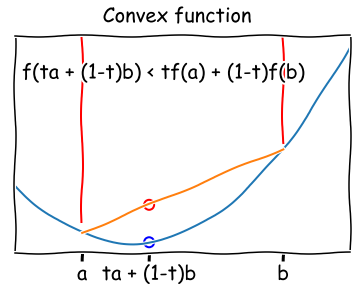

In [30]:
def f(x):
    return (x-4)**2 + x + 1

with plt.xkcd():
    x = np.linspace(0, 10, 100)

    plt.plot(x, f(x))
    ymin, ymax = plt.ylim()
    plt.axvline(2, ymin, f(2)/ymax, c='red')
    plt.axvline(8, ymin, f(8)/ymax, c='red')
    plt.scatter([4, 4], [f(4), f(2) + ((4-2)/(8-2.))*(f(8)-f(2))],
                 edgecolor=['blue', 'red'], facecolor='none', s=100, linewidth=2)
    plt.plot([2,8], [f(2), f(8)])
    plt.xticks([2,4,8], ('a', 'ta + (1-t)b', 'b'), fontsize=20)
    plt.text(0.2, 40, 'f(ta + (1-t)b) < tf(a) + (1-t)f(b)', fontsize=20)
    plt.xlim([0,10])
    plt.yticks([])
    plt.suptitle('Convex function', fontsize=20)

Warm up exercise

Show that $f(x)=−log(x)$ is a convex function.
Checking if a function is convex using the Hessian

The formal definition is only useful for checking if a function is convex if you can find a counter-example. More practically, a twice differentiable function is convex if its Hessian is positive semi-definite, and strictly convex if the Hessian is positive definite.

For example, suppose we want to minimize the scalar-valued function
$$f(x_1,x_2,x_3)=x_2^1+2x_2^2+3x^2_3+2x_1x_2+2x_1x_3$$

In [30]:
from sympy import symbols, hessian, Function, init_printing, expand, Matrix, diff
x, y, z = symbols('x y z')
f = symbols('f', cls=Function)
init_printing()

In [31]:
f = x**2 + 2*y**2 + 3*z**2 + 2*x*y + 2*x*z
print(f)

x**2 + 2*x*y + 2*x*z + 2*y**2 + 3*z**2


In [32]:
H = hessian(f, (x, y, z))
print(H)

Matrix([[2, 2, 2], [2, 4, 0], [2, 0, 6]])


In [33]:
np.real_if_close(la.eigvals(np.array(H).astype('float')))

array([0.241, 7.064, 4.695])

Since the matrix is symmetric and all eigenvalues are positive, the Hessian is positive defintie and the function is convex.

Combining convex functions

The following rules may be useful to determine if more complex functions are convex:

    1.The intersection of convex functions is convex
    2.If the functions f and g are convex and a≥0 and b≥0 then the function af+bg is convex.
    3.If the function U is convex and the function g is nondecreasing and convex then the function f defined by f(x)=g(U(x)) is convex.


##### Are there any constraints that the solution must meet?

In general, optimization without constraints is easier to perform than optimization in the presence of constraints. The solutions may be very different in the presence or absence of constraints, so it is important to know if there are any constraints.

We will see some examples of two general strategies: - convert a problem with constraints into one without constraints or - use an algorithm that can optimize with constraints.


### Using scipy.optimize
One of the most convenient libraries to use is scipy.optimize, since it is already part of the Anaconda installation and it has a fairly intuitive interface.

In [34]:
from scipy import optimize as opt

In [35]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

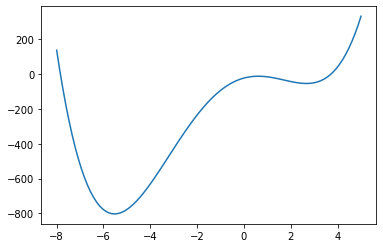

In [36]:
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

In [37]:
opt.minimize_scalar(f, method='Brent')

     fun: -803.3955308825884
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663

In [38]:
opt.minimize_scalar(f, method='bounded', bounds=[0, 6])

     fun: -54.21003937712762
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 2.668865104039653

##### Local and global minima

In [39]:
def f(x, offset):
    return -np.sinc(x-offset)

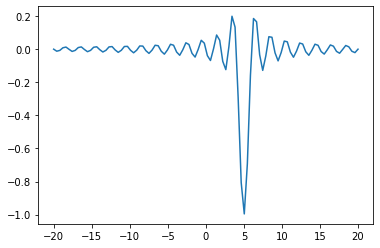

In [40]:
x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [41]:
# note how additional function arguments are passed in
sol = opt.minimize_scalar(f, args=(5,))
sol

     fun: -0.049029624014074166
    nfev: 15
     nit: 10
 success: True
       x: -1.4843871263953001

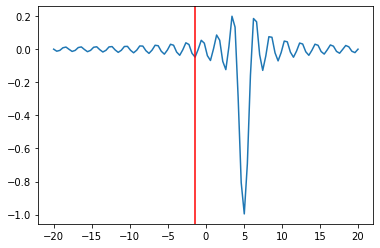

In [42]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red')
pass

In [43]:
# We can try multiple random starts to find the global minimum
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [opt.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [44]:
idx = np.argmin([sol.fun for sol in sols])
sol = sols[idx]

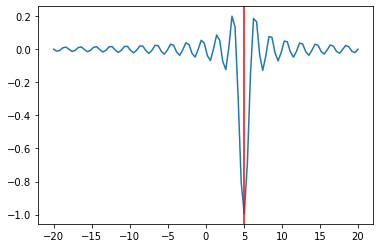

In [45]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

In [46]:
from scipy.optimize import basinhopping

In [47]:
x0 = 0
sol = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

                        fun: -0.07091345945046215
 lowest_optimization_result:       fun: -0.07091345945046215
 hess_inv: array([[1.429]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([0.523])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1422
                        nit: 100
                       njev: 711
                          x: array([0.523])

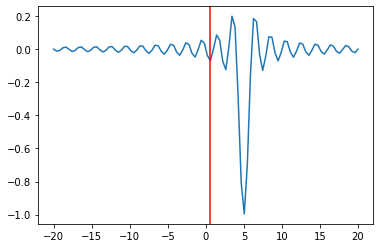

In [48]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

Conditioning of optimization problem

With these values for a
and b, the problem is ill-conditioned. As we shall see, one of the factors affecting the ease of optimization is the condition number of the curvature (Hessian). When the condition number is high, the gradient may not point in the direction of the minimum, and simple gradient descent methods may be inefficient since they may be forced to take many sharp turns.

In [ ]:
from sympy import symbols, hessian, Function, N

x, y = symbols('x y')
f = symbols('f', cls=Function)

f = 100*(y - x**2)**2 + (1 - x)**2

H = hessian(f, [x, y]).subs([(x,1), (y,1)])
H, N(H.condition_number())

In [ ]:
# As pointed out in the previous lecture, the condition number is basically the ratio of largest to smallest eigenvalue of the Hessian
import scipy.linalg as la

mu = la.eigvals(np.array([802, -400, -400, 200]).reshape((2,2)))
np.real_if_close(mu[0]/mu[1])

In [ ]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)

In [ ]:
# Why is the condition number so large?
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

In [ ]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

In [ ]:
# Zooming in to the global minimum at (1,1)
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

In [ ]:
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

### Gradient descent
The gradient (or Jacobian) at a point indicates the direction of steepest ascent. Since we are looking for a minimum, one obvious possibility is to take a step in the opposite direction to the gradient. We weight the size of the step by a factor $α$ known in the machine learning literature as the learning rate. If $α$ is small, the algorithm will eventually converge towards a local minimum, but it may take long time. If $α$ is large, the algorithm may converge faster, but it may also overshoot and never find the minimum. Gradient descent is also known as a first order method because it requires calculation of the first derivative at each iteration.

Some algorithms also determine the appropriate value of $α$ at each stage by using a line search, i.e.,
$$α^∗=argmin_αf(x_k−α∇f(x_k))$$

which is a 1D optimization problem.

As suggested above, the problem is that the gradient may not point towards the global minimum especially when the condition number is large, and we are forced to use a small $α$ for convergence.

Let’s warm up by minimizing a trivial function $f(x,y)=x^2+y^2$ to illustrate the basic idea of gradient descent.

In [ ]:
def f(x):
    return x[0]**2 + x[1]**2

def grad(x):
    return np.array([2*x[0], 2*x[1]])

a = 0.1 # learning rate
x0 = np.array([1.0,1.0])
print('Start', x0)
for i in range(41):
    x0 -= a * grad(x0)
    if i%5 == 0:
        print(i, x0)

#### Gradient descent for least squares minimization

Usually, when we optimize, we are not just finding the minimum, but also want to know the parameters that give us the minimum. As a simple example, suppose we want to find parameters that minimize the least squares difference between a linear model and some data. Suppose we have some data $(0,1),(1,2),(2,3),(3,3.5),(4,6),(5,9),(6,8)$ and want to find a line $y=β_0+β_1x$ that is the best least squares fit. One way to do this is to solve $X^TXβ^^=X^Ty$, but we want to show how this can be formulated as a gradient descent problem.
We want to find $β=(β_0,β_1)$ that minimize the squared differences
$$r=∑(β_0+β_1x−y)^2$$

In [ ]:
def f(x, y, b):
    """Helper function."""
    return (b[0] + b[1]*x - y)

def grad(x, y, b):
    """Gradient of objective function with respect to parameters b."""
    n = len(x)
    return np.array([
            sum(f(x, y, b)),
            sum(x*f(x, y, b))
    ])

In [ ]:
x, y = map(np.array, zip((0,1), (1,2), (2,3), (3,3.5), (4,6), (5,9), (6,8)))

In [ ]:
a = 0.001 # learning rate
b = np.zeros(2)
for i in range(10000):
    b -= a * grad(x, y, b)
b

In [ ]:
plt.scatter(x, y, s=30)
plt.plot(x, b[0] + b[1]*x, color='red')
pass

### Gradient descent to minimize the Rosen function using scipy.optimize

Because gradient descent is unreliable in practice, it is not part of the scipy optimize suite of functions, but we will write a custom function below to illustrate how to use gradient descent while maintaining the scipy.optimize interface.

In [ ]:
def rosen_der(x):
    """Derivative of generalized Rosen function."""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

Warning One of the most common causes of failure of optimization is because the gradient or Hessian function is specified incorrectly. You can check for this using check_grad which compares the analytical gradient with one calculated using finite differences.

In [ ]:
from scipy.optimize import check_grad

for x in np.random.uniform(-2,2,(10,2)):
    print(x, check_grad(rosen, rosen_der, x))

In [ ]:
# Writing a custom function for the scipy.optimize interface.
def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the Rosen function."""
    bestx = x0
    bestf = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * rosen_der(bestx)
        bestx = bestx - step

        bestf = fun(bestx)
        funcalls += 1

        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=bestf, x=bestx, nit=niter,
                              nfev=funcalls, success=(niter > 1))

In [ ]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

In [ ]:
# Initial starting position
x0 = np.array([4,-4.1])

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method=custmin, callback=reporter)

In [ ]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### First order methods

As calculating the Hessian is computationally expensive, sometimes first order methods that only use the first derivatives are preferred. Quasi-Newton methods use functions of the first derivatives to approximate the inverse Hessian. A well know example of the Quasi-Newoton class of algorithjms is BFGS, named after the initials of the creators. As usual, the first derivatives can either be provided via the jac= argument or approximated by finite difference methods.

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method='BFGS', callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### Second order methods

Second order methods solve for H^−1 and so require calculation of the Hessian (either provided or approximated using finite differences). For efficiency reasons, the Hessian is not directly inverted, but solved for using a variety of methods such as conjugate gradient. An example of a second order method in the optimize package is Newton-GC.

In [ ]:
from scipy.optimize import rosen, rosen_der, rosen_hess

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method='Newton-CG', jac=rosen_der, hess=rosen_hess, callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### Zeroth order methods

Finally, there are some optimization algorithms not based on the Newton method, but on other heuristic search strategies that do not require any derivatives, only function evaluations. One well-known example is the Nelder-Mead simplex algorithm.

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method='nelder-mead', callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### Lagrange multipliers and constrained optimization
Recall why Lagrange multipliers are useful for constrained optimization - a stationary point must be where the constraint surface $g$ touches a level set of the function $f$ (since the value of $f$ does not change on a level set). At that point, $f$ and $g$ are parallel, and hence their gradients are also parallel (since the gradient is normal to the level set). So we want to solve
$$∇f=−λ∇g$$

or equivalently,
$$∇f+λ∇g=0$$

#### Numerical example of using Lagrange multipliers

Maximize $f(x,y,z)=xy+yz$ subject to the constraints $x+2y=6$ and $x−3z=0$

We set up the equations
$$F(x,y,z,λ,μ)=xy+yz−λ(x+2y−6)−μ(x−3z)$$

In [ ]:
A = np.array([
    [0, 1, 0, -1, -1],
    [1, 0, 1, -2, 0],
    [0, 1, 0, 0, 3],
    [1, 2, 0, 0, 0],
    [1, 0,-3, 0, 0]])

b = np.array([0,0,0,6,0])

sol = la.solve(A, b)

In [ ]:
sol

In [ ]:
def f(x, y, z):
    return x*y + y*z

In [ ]:
f(*sol[:3])

### Check using scipy.optimize

In [ ]:
# Convert to minimization problem by negating function
def f(x):
    return -(x[0]*x[1] + x[1]*x[2])

In [ ]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0] + 2*x[1] - 6, x[0] - 3*x[2]])})

In [ ]:
x0 = np.array([2,2,0.67])
cx = opt.minimize(f, x0, constraints=cons)
cx